In [1]:
import osmnx as ox
import igraph as ig
import pandas as pd
import networkx as nx
import numpy as np
import multiprocessing as mp
import time
import random as rd
from itertools import product
import ast
from numpy import inf
import matplotlib.pyplot as plt
from IPython.display import clear_output
import scipy
import itertools
import math

# Beta Data:

In [2]:
def beta_bin_calculator(dataframe, sample_mode):
    
    L_from = list(dataframe['L from length'])
    L_to = list(dataframe['L to length'])
    L_tuple = [(round(l_from,0), round(l_to,0)) for l_from, l_to in zip(L_from, L_to) if l_from!=0 and l_from!=-1 and l_to!=0 and l_to!=-1]
    
    L_from_clean = [val[0] for val in L_tuple]
    log_r = [np.log(val[1]/val[0]) for val in L_tuple]
    
    if sample_mode:
    
        sample_index = np.random.choice(len(L_from_clean), 100000, replace=True)
        sample_log_r = [log_r[i] for i in sample_index]
        sample_L_from = [L_from_clean[i] for i in sample_index]

        minimo=100
        maximo = max(sample_L_from)
        n_bins=15
        bins=(np.e)**np.linspace(np.log(minimo),np.log(maximo),n_bins)

        log_r_bin = []
        for b in range(n_bins-1):
            new_bin = []
            for j in range(len(sample_L_from)):
                if sample_L_from[j]>bins[b] and sample_L_from[j]<bins[b+1]:
                    new_bin.append(sample_log_r[j])
            log_r_bin.append(new_bin)
            
        std_per_bin = [np.nanstd(lista) for lista in log_r_bin]
            
    else:
        
        minimo=100
        maximo = max(L_from_clean)
        n_bins=15
        bins=(np.e)**np.linspace(np.log(minimo),np.log(maximo),n_bins)

        log_r_bin = []
        for b in range(n_bins-1):
            new_bin = []
            for j in range(len(L_from_clean)):
                if L_from_clean[j]>bins[b] and L_from_clean[j]<bins[b+1]:
                    new_bin.append(log_r[j])
            log_r_bin.append(new_bin)
        
        std_per_bin = [np.nanstd(lista) for lista in log_r_bin]
    
    return std_per_bin, bins

In [3]:
def beta_sampler(city, sample_mode, number):
    data = pd.read_csv('/home/diogo_mota/Dropbox/Diogo_Rede_simetria/Shuffle_data/'+city+'_teste/'+city+'_FULL_100k_paths_shuffle.dat', index_col=0)


    std_list = []
    bins_list = []

    for k in range(number):
        print(k)
        std_per_bin, bins = beta_bin_calculator(data, sample_mode)

        std_list.append(std_per_bin)
        bins_list.append(bins)
        clear_output(True)
    return std_list, bins_list

# Slope calculation:

In [4]:
def beta_calculator(bins, std_list, left_lim, right_lim):
    
    x = 0.5*(bins[:-1]+bins[1:])
    log_x = np.array([np.log(v) for v in x])
    
    y = [y for y in std_list]
    log_y = np.array([np.log(w) for w in y])
        
    log_y = log_y[log_x>np.log(left_lim)]
    log_x = log_x[log_x>np.log(left_lim)]
    
    log_y = log_y[log_x<np.log(right_lim)]
    log_x = log_x[log_x<np.log(right_lim)]
    
    indices = [i for i in range(len(log_y)) if math.isinf(log_y[i])==False and math.isnan(log_y[i])==False]
    
    log_y = [log_y[j] for j in indices]
    log_x = [log_x[k] for k in indices]
    
    results = scipy.stats.linregress(log_x, log_y)
    
    return results

In [5]:
def betas_calc(bins_list, std_list, left_lim, right_lim, number):
    
    betas = []
    lin_err = []
    inter = []
    
    for i in range(number):
        
        res = beta_calculator(bins_list[i], std_list[i],
                              left_lim, right_lim)
        
        betas.append(res.slope)
        lin_err.append(res.stderr)
        inter.append(res.intercept)
    
    indices = [j for j in range(len(betas)) if np.isnan(betas[j])==False]
    
    betas_clean = [betas[j] for j in indices]
    lin_errors_clean = [lin_err[k] for k in indices]
    inter_clean = [inter[p] for p in indices]
    
    return np.nanmean(betas_clean), np.nanmean(lin_errors_clean), np.nanmean(inter_clean), np.nanstd(inter_clean)

In [6]:
cities = ['Amsterdam', 'Berlin','Boston', 'Fortaleza', 'Lisbon','Madrid','Manhattan', 'Paris', 'Rome', 'San_Francisco']

In [7]:
r_sample_data = {}

for city in cities:

    std_beta, bins_beta = beta_sampler(city, True, 100)
    
    r_sample_data[city] = {'sigma_r_list': std_beta, 'bins_r': bins_beta}

99


In [8]:
r_data = {}

for city in cities:
    data = pd.read_csv('/home/diogo_mota/Dropbox/Diogo_Rede_simetria/Shuffle_data/'+city+'_teste/'+city+'_FULL_100k_paths_shuffle.dat', 
                       index_col=0)

    std_beta, bins_beta = beta_bin_calculator(data, False)
    
    r_data[city] = {'sigma_r_list':std_beta, 'bins_r': bins_beta}

In [9]:
np.save('/home/diogo_mota/Dropbox/Diogo_Rede_simetria/sigma_r_shuffle_data_dictionary.npy', 
        r_data) 

In [10]:
#beta_val, beta_error, beta_inter, beta_inter_err = betas_calc(r_sample_data['Paris']['bins_r'], 
 #                                                             r_sample_data['Paris']['sigma_r_list'],
  #                                                            800, 10**4.5, 100)
#print(beta_val, beta_error)

In [11]:
right_lim = np.linspace(10**4, 10**4.5, 5)
left_lim = [v for v in range(100, 1000, 25)]

dist_comb = list(itertools.product(left_lim, right_lim))

In [29]:
beta_data = {}

for key in r_sample_data.keys():
    
    beta_val_list = []
    beta_error_list = []
    beta_intercept_list = []
    beta_intercept_error_list = []

    for value in dist_comb:

        left = value[0]
        right = value[1]

        beta_val, beta_error, beta_inter, beta_inter_err = betas_calc(r_sample_data[key]['bins_r'], 
                                                                      r_sample_data[key]['sigma_r_list'],
                                                                      left, right, 100)

        beta_val_list.append(beta_val)
        beta_error_list.append(beta_error)
        beta_intercept_list.append(beta_inter)
        beta_intercept_error_list.append(beta_inter_err)


    beta_data[key] = {'min_left':dist_comb[beta_error_list.index(min(beta_error_list))][0],
                      'min_right':dist_comb[beta_error_list.index(min(beta_error_list))][1],
                       'best_beta':beta_val_list[beta_error_list.index(min(beta_error_list))], 
                       'best_intercept':beta_intercept_list[beta_error_list.index(min(beta_error_list))], 
                       'beta_error':beta_error_list[beta_error_list.index(min(beta_error_list))], 
                       'intercept_error':beta_intercept_error_list[beta_error_list.index(min(beta_error_list))],
                       'beta_val_list':beta_val_list, 'beta_error_list':beta_error_list, 
                      'beta_intercept_list':beta_intercept_list, 
                       'beta_intercept_error':beta_intercept_error_list}

<ipython-input-4-0974fc7180c2>:7: RuntimeWarning: divide by zero encountered in log
  log_y = np.array([np.log(w) for w in y])


In [30]:
## foi para melhorar o fit de acordo com os plots (PARA O SEM SHUFFLE)

for key in beta_data.keys():

    if key=='Boston':

        beta_val, beta_error, beta_inter, beta_inter_err = betas_calc(r_sample_data[key]['bins_r'], 
                                                                      r_sample_data[key]['sigma_r_list'],
                                                                      10**2.5, beta_data[key]['min_right'],
                                                                      100)
        beta_data[key] = {'min_left':10**2.5,
                  'min_right':beta_data[key]['min_right'],
                   'best_beta':beta_val, 
                   'best_intercept':beta_inter, 
                   'beta_error':beta_error, 
                   'intercept_error': beta_inter_err}
        
    if key=='Fortaleza':

        beta_val, beta_error, beta_inter, beta_inter_err = betas_calc(r_sample_data[key]['bins_r'], 
                                                                      r_sample_data[key]['sigma_r_list'],
                                                                      10**2.5, beta_data[key]['min_right'],
                                                                      100)
        beta_data[key] = {'min_left':10**2.5,
                  'min_right':beta_data[key]['min_right'],
                   'best_beta':beta_val, 
                   'best_intercept':beta_inter, 
                   'beta_error':beta_error, 
                   'intercept_error': beta_inter_err}
        
    if key=='Paris':

        beta_val, beta_error, beta_inter, beta_inter_err = betas_calc(r_sample_data[key]['bins_r'], 
                                                                      r_sample_data[key]['sigma_r_list'],
                                                                      10**2.4, 10**4.2, 100)
        beta_data[key] = {'min_left':10**2.4,
                  'min_right':10**4.2,
                   'best_beta':beta_val, 
                   'best_intercept':beta_inter, 
                   'beta_error':beta_error, 
                   'intercept_error': beta_inter_err}
        
        
    if key=='Rome':

        beta_val, beta_error, beta_inter, beta_inter_err = betas_calc(r_sample_data[key]['bins_r'], 
                                                                      r_sample_data[key]['sigma_r_list'],
                                                                      beta_data[key]['min_left'], 10**4.05, 
                                                                      100)
        beta_data[key] = {'min_left':beta_data[key]['min_left'],
                  'min_right':10**4.05,
                   'best_beta':beta_val, 
                   'best_intercept':beta_inter, 
                   'beta_error':beta_error, 
                   'intercept_error': beta_inter_err}
        
    if key=='San_Francisco':

        beta_val, beta_error, beta_inter, beta_inter_err = betas_calc(r_sample_data[key]['bins_r'], 
                                                                      r_sample_data[key]['sigma_r_list'],
                                                                      10**2.2, beta_data[key]['min_right'], 
                                                                      100)
        beta_data[key] = {'min_left':10**2.2,
                  'min_right':beta_data[key]['min_right'],
                   'best_beta':beta_val, 
                   'best_intercept':beta_inter, 
                   'beta_error':beta_error, 
                   'intercept_error': beta_inter_err}
        
    else:
        pass
        

<ipython-input-4-0974fc7180c2>:7: RuntimeWarning: divide by zero encountered in log
  log_y = np.array([np.log(w) for w in y])


In [31]:
np.save('/home/diogo_mota/Dropbox/Diogo_Rede_simetria/beta_shuffle_data_dictionary.npy', 
        beta_data) 

In [32]:
beta_cities = [beta_data[city]['best_beta'] for city in beta_data.keys()]

std_cities = [beta_data[city]['beta_error'] for city in beta_data.keys()]

In [33]:
beta_cities

[-0.4844936677618572,
 -0.45491359548638116,
 -0.519411891428955,
 -0.5652216713274728,
 -0.4814565444475022,
 -0.5228398994640743,
 -0.5337913224126167,
 -0.5734027341229501,
 -0.42776537420753624,
 -0.5255705773574525]

In [34]:
std_cities

[0.01885268469154497,
 0.026704067911423778,
 0.032027620660093986,
 0.034515913207814566,
 0.01664316659399756,
 0.025202900813592524,
 0.015989200657541065,
 0.025052203519167072,
 0.03906320055263782,
 0.04369900448245124]

In [35]:
df = pd.DataFrame(zip(beta_cities, std_cities), columns = ['beta', 'std'], index = ['Amsterdam', 'Berlin','Boston', 'Fortaleza', 'Lisbon','Madrid','Manhattan', 'Paris', 'Rome', 'San_Francisco'])

In [36]:
df

,beta,std
Amsterdam,-0.484494,0.018853
Berlin,-0.454914,0.026704
Boston,-0.519412,0.032028
Fortaleza,-0.565222,0.034516
Lisbon,-0.481457,0.016643
Madrid,-0.522840,0.025203
Manhattan,-0.533791,0.015989
Paris,-0.573403,0.025052
Rome,-0.427765,0.039063
San_Francisco,-0.525571,0.043699


In [37]:
df.to_csv('/home/diogo_mota/Dropbox/Diogo_Rede_simetria/Average_betas_distance_method_final_shuffle.dat')

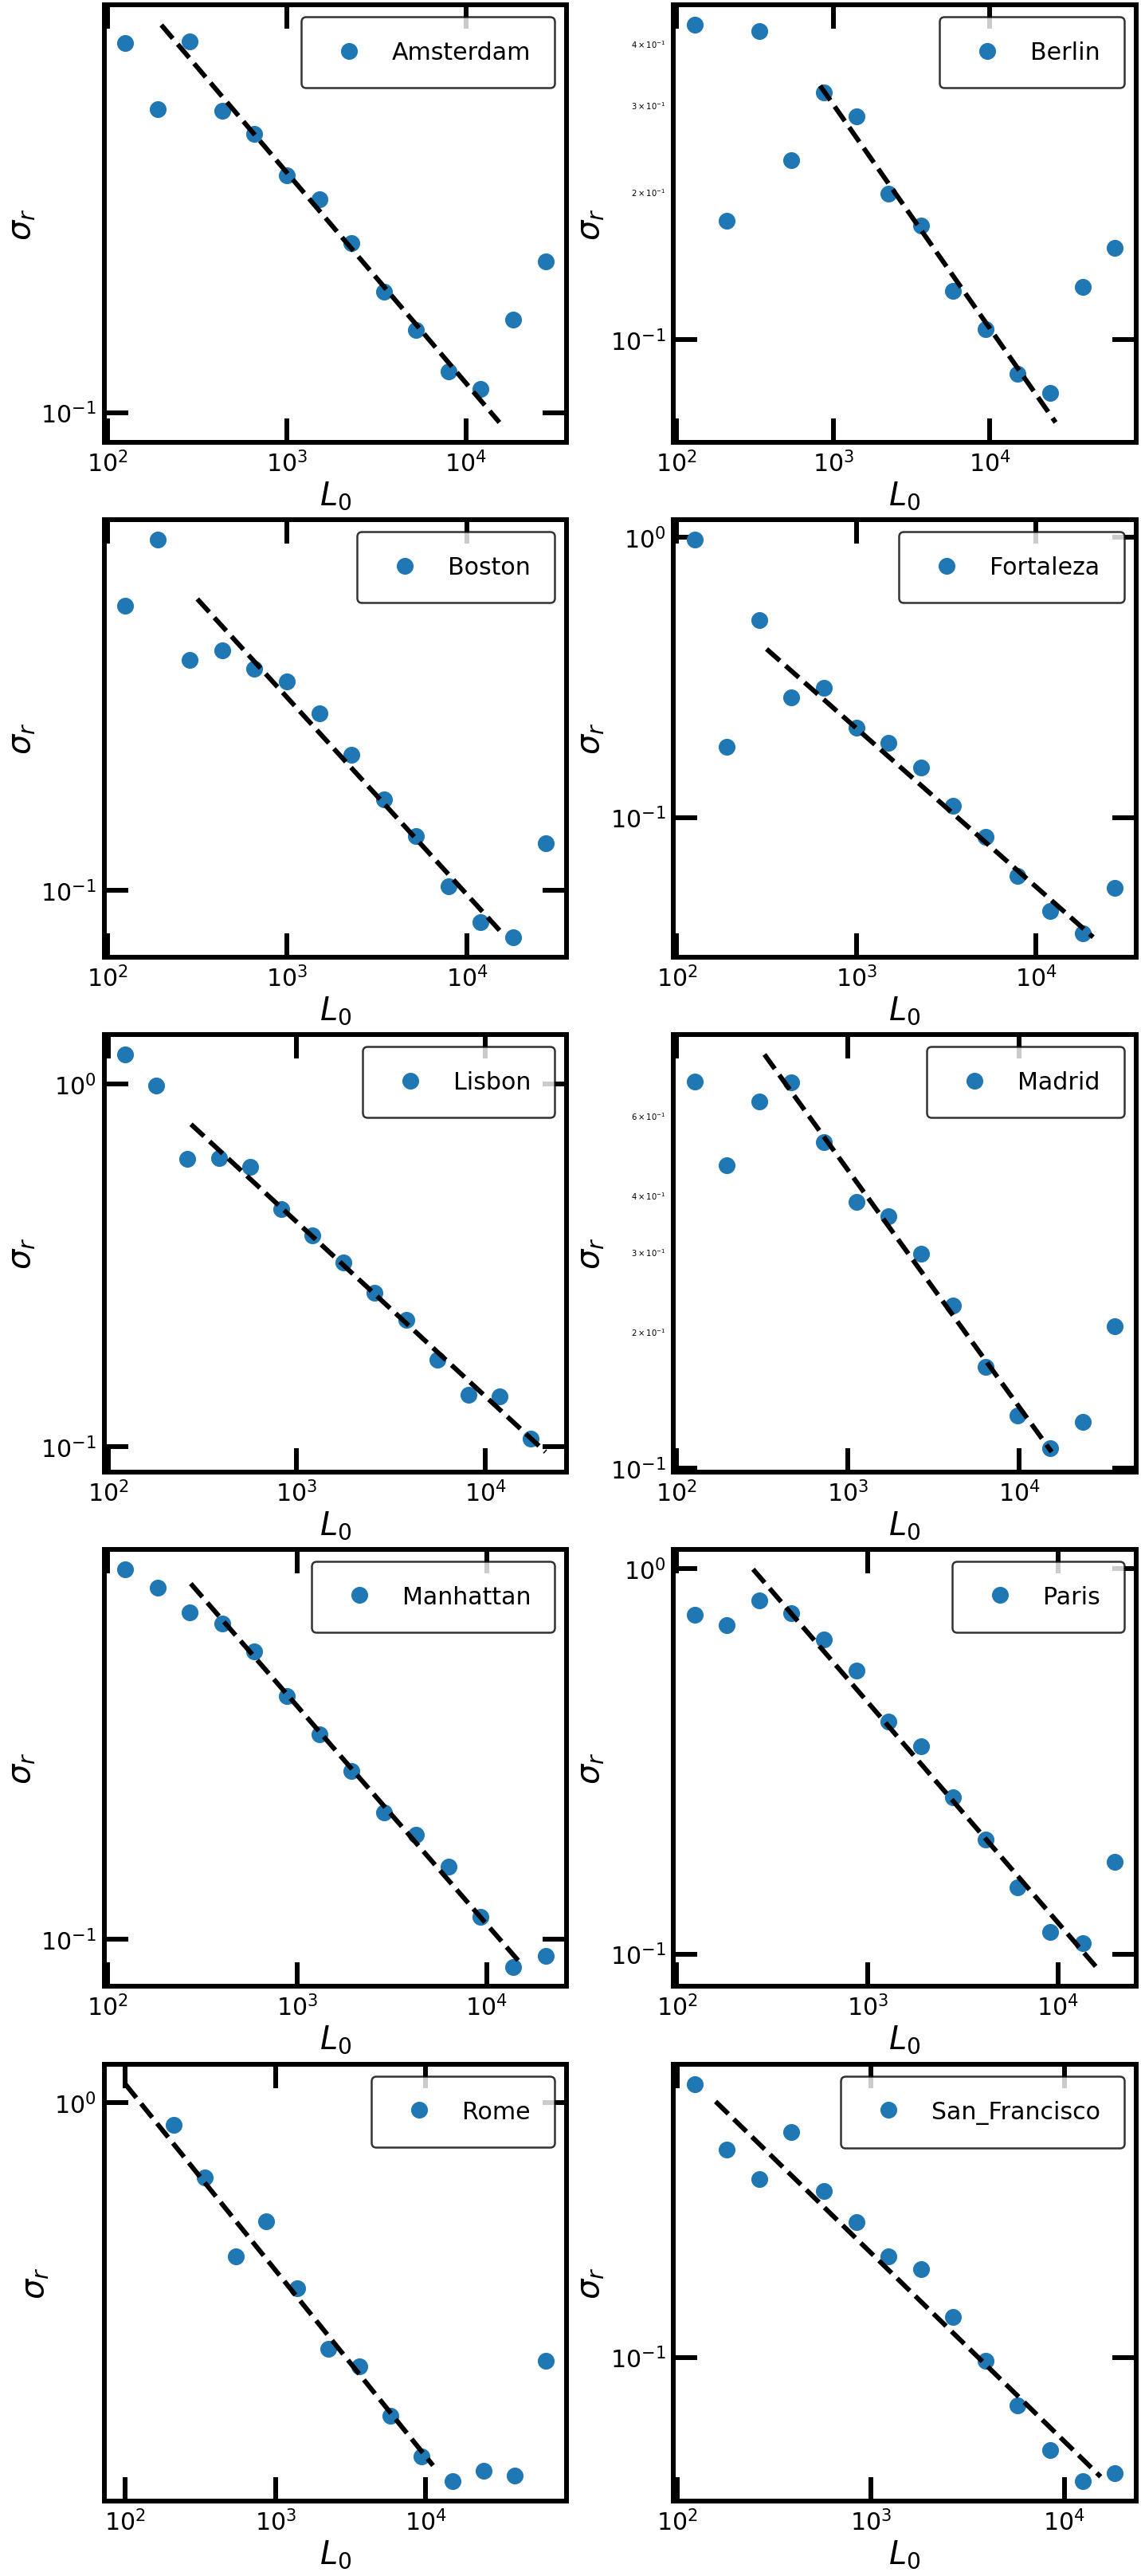

In [39]:
fig, axs = plt.subplots(5,2, figsize=(20,45))
s = 100
axs = axs.ravel()
for city in cities:
    #print(city)
    i=cities.index(city)
    
    
    axs[i].plot((0.5*(r_data[city]['bins_r'][:-1]+r_data[city]['bins_r'][1:])), 
                r_data[city]['sigma_r_list'], 'o', markersize=20, label=city)
    
    xx = 10**(np.linspace(np.log10(beta_data[city]['min_left']), 
                          np.log10(beta_data[city]['min_right']), 10))

        
    yy = (np.exp(beta_data[city]['best_intercept']))*(xx)**beta_data[city]['best_beta']
    axs[i].plot(xx, yy, '--', color='black', linewidth=6)


    for axis in ['top','bottom','left','right']:
        axs[i].spines[axis].set_linewidth(6)

    axs[i].set_xlabel('$L_{0}$', fontsize=40)
    axs[i].xaxis.set_ticks_position('both')
    axs[i].set_ylabel('$\sigma_{r}}$', fontsize=40)
    axs[i].yaxis.set_ticks_position('both')
    axs[i].tick_params(which='both', length=30, width=6, direction="in", pad=10)
    axs[i].tick_params(which='minor', length=0)


    axs[i].tick_params(labelsize=30)
    legend = axs[i].legend(borderpad=1, labelspacing=2, fontsize=30, loc='upper right')
    legend.get_frame().set_linewidth(2.5)
    legend.get_frame().set_edgecolor('black')
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
plt.tight_layout()
fig.savefig('/home/diogo_mota/Dropbox/Diogo_Rede_simetria/Beta_fits_final.png',  facecolor='white')